# Team Members
Pearlina Tan & Jolynn Tan


# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

zsh:1: no matches found: gym[classic_control]


## Importing dependencies and define helper functions

In [23]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
#import tensorflow as tf
#from tensorflow import keras
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [2]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [3]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [4]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [5]:
observation, _ = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02526319 -0.02133585 -0.03606655 -0.01197244]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [24]:
observation, reward, done, info, _ = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.34547424 -0.16800494 -0.00505015  0.25444582]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [7]:
observation = env.reset()[0]
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info, _ = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


In [8]:
gym.__version__

'0.26.2'

## Task 1: Development of an RL agent

# Algorithm used:

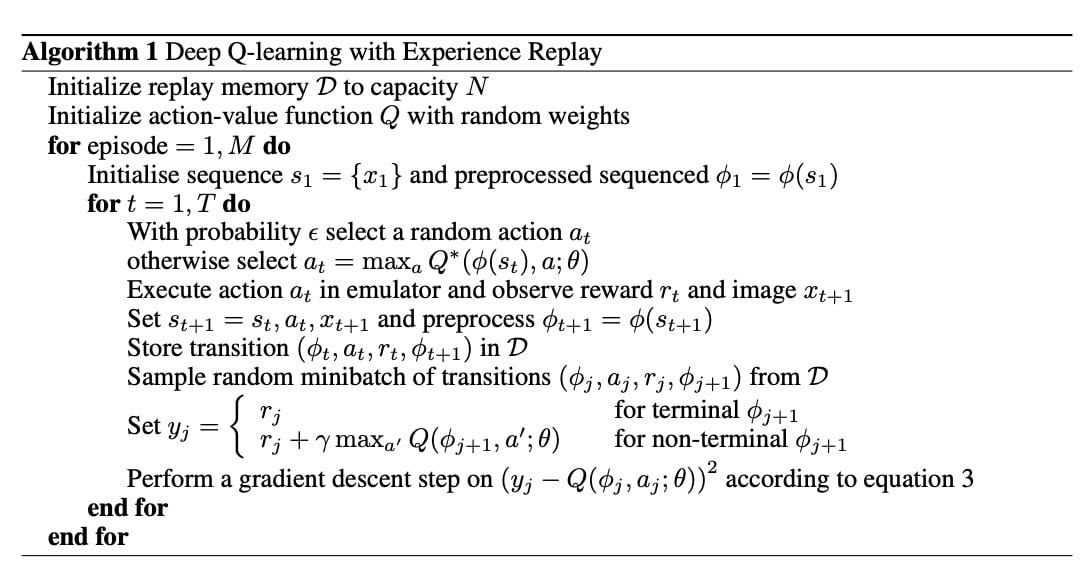


A DQN, or Deep Q-Network, approximates a state-value function in a Q-Learning framework directly with a neural network. The TD update is gradually shifting the Q value for (s,a) towards r+max a Q(s′,a). It eventually converges to the optimal Q-function.

Experience Replay is a technique used alongside DQN (Deep Q-Network) to make learning more efficient. Instead of learning only from recent experiences, the system stores past experiences in memory. This helps prevent the learning process from being biased by recent events and allows the system to learn from a variety of situations.




In [9]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


In [10]:
class DeepQNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir=r"C:\Users\Pearlina\SC3000"):

        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_dqn.pt')
        self.fc1 = nn.Linear(*(self.input_dims), self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        #f2 = 0.002
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        f3 = 0.003
        self.q = nn.Linear(self.fc2_dims, n_actions)
        T.nn.init.uniform_(self.q.weight.data, -f3, f3)
        T.nn.init.uniform_(self.q.bias.data, -f3, f3)

        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        q_values = self.q(x)
        return q_values

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


In [11]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 50

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256, name='Q_Network')
        self.Target_Q_network = DeepQNetwork(lr, n_actions=n_actions,
                                           input_dims=input_dims,
                                           fc1_dims=256, fc2_dims=256, name='Target_Q_Network')

        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

        self.Target_Q_network.load_state_dict(self.Q_eval.state_dict())

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(np.array(observation)).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action
    
    def choose_action_test_stage(self, observation):

        state = T.tensor(np.array(observation)).to(self.Q_eval.device)
        actions = self.Q_eval.forward(state)
        action = T.argmax(actions).item()

        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
            self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
            self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
            self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Target_Q_network.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1

        # Periodically update the target network by Q network to target Q network
        if self.iter_cntr % self.replace_target == 0:
            self.Target_Q_network.load_state_dict(self.Q_eval.state_dict())

        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.Q_eval.save_checkpoint()
        self.Target_Q_network.save_checkpoint()


    def load_models(self):
        self.Q_eval.load_checkpoint()
        self.Target_Q_network.load_checkpoint()


# Training the agent until it achieves a score of 500 consistently.

In [12]:
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01,
              input_dims=[4], lr=0.001)
scores, score_history = [], []
n_games = 500

for i in range(n_games):
    score = 0
    done = False
    observation, _ = env.reset()
    for j in range(500):
        action = agent.choose_action(observation)
        observation_, reward, done, info, _ = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward,
                               observation_, done)
        agent.learn()
        observation = observation_
        env.render()

    score_history.append(score)
    print('episode ', i, 'score %.2f' % score,
          'trailing 10 games avg %.3f' % np.mean(score_history[-10:]))
    if np.mean(score_history[-10:] == 500):
               break

#agent.save_models()
#agent.load_models()


episode  0 score 17.00 trailing 10 games avg 17.000
episode  1 score 21.00 trailing 10 games avg 19.000
episode  2 score 40.00 trailing 10 games avg 26.000
episode  3 score 347.00 trailing 10 games avg 106.250
episode  4 score 423.00 trailing 10 games avg 169.600
episode  5 score 358.00 trailing 10 games avg 201.000
episode  6 score 267.00 trailing 10 games avg 210.429
episode  7 score 205.00 trailing 10 games avg 209.750
episode  8 score 275.00 trailing 10 games avg 217.000
episode  9 score 253.00 trailing 10 games avg 220.600
episode  10 score 171.00 trailing 10 games avg 236.000
episode  11 score 278.00 trailing 10 games avg 261.700
episode  12 score 203.00 trailing 10 games avg 278.000
episode  13 score 212.00 trailing 10 games avg 264.500
episode  14 score 474.00 trailing 10 games avg 269.600
episode  15 score 205.00 trailing 10 games avg 254.300
episode  16 score 229.00 trailing 10 games avg 250.500
episode  17 score 425.00 trailing 10 games avg 272.500
episode  18 score 250.00 t

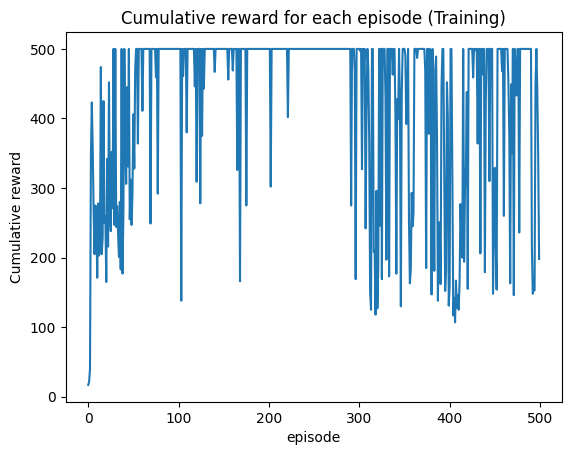

In [13]:
plt.plot(score_history)
plt.title('Cumulative reward for each episode (Training)')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [14]:
agent.save_models()

... saving checkpoint ...
... saving checkpoint ...


In [15]:
agent.load_models()

... loading checkpoint ...
... loading checkpoint ...


For Task 1, we can show the observation and chosen action below:

In [16]:
observation, _ = env.reset()
action = agent.choose_action_test_stage(observation)
print("Observation:", observation)
print("Chosen action:", action)


Observation: [-0.02411406  0.04273778  0.03182255 -0.000131  ]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

# We proceed to test the Agent for 100 episodes

In [64]:
# env = gym.make("CartPole-v1")
# agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01,
#               input_dims=[4], lr=0.001)

In [17]:

agent.load_models()
score_history_test = []
for i in range(100):
    score = 0
    done = False
    observation, _ = env.reset()
    for j in range(500):
        action = agent.choose_action_test_stage(observation)
        observation_, reward, done, info, _ = env.step(action)
        score += reward
        observation = observation_
        # env.render()

    score_history_test.append(score)
    print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history_test[-100:]))

... loading checkpoint ...
... loading checkpoint ...
episode  0 score 500.00 trailing 100 games avg 500.000
episode  1 score 500.00 trailing 100 games avg 500.000
episode  2 score 500.00 trailing 100 games avg 500.000
episode  3 score 500.00 trailing 100 games avg 500.000
episode  4 score 500.00 trailing 100 games avg 500.000
episode  5 score 500.00 trailing 100 games avg 500.000
episode  6 score 500.00 trailing 100 games avg 500.000
episode  7 score 500.00 trailing 100 games avg 500.000
episode  8 score 500.00 trailing 100 games avg 500.000
episode  9 score 500.00 trailing 100 games avg 500.000
episode  10 score 500.00 trailing 100 games avg 500.000
episode  11 score 500.00 trailing 100 games avg 500.000
episode  12 score 500.00 trailing 100 games avg 500.000
episode  13 score 500.00 trailing 100 games avg 500.000
episode  14 score 500.00 trailing 100 games avg 500.000
episode  15 score 500.00 trailing 100 games avg 500.000
episode  16 score 500.00 trailing 100 games avg 500.000
epis

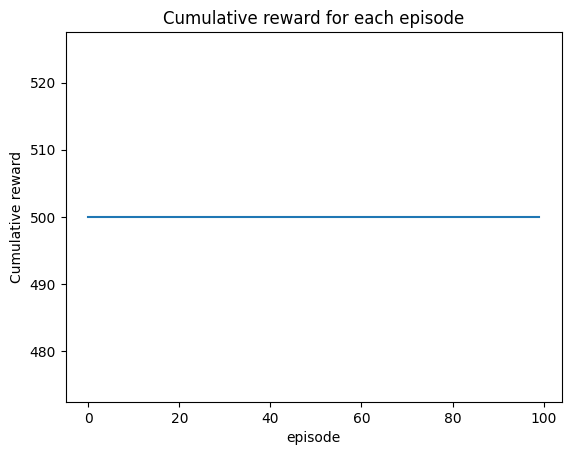

In [18]:
plt.plot(score_history_test)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [19]:
print("Average cumulative reward:", sum(score_history_test)/len(score_history_test))
print("Is my agent good enough?", sum(score_history_test)/len(score_history_test) > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [25]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = RecordVideo(env, r"C:\Users\Pearlina\SC3000")
observation, _ = env.reset()
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01, input_dims=[4], lr=0.001)
agent.load_models()
total_rewards = []
done = False

for i in range(600):
    # env.render(mode='rgb_array')
    #your agent goes here
    action = agent.choose_action_test_stage(observation)
    #action = theta_omega_policy(state)
    observation, reward, done, info, _ = env.step(action)
    total_rewards += [reward]

    if done:
        break
        

env.close()
show_video()

# print(total_rewards)
print(f'Final rewards: {sum(total_rewards)}')


... loading checkpoint ...
... loading checkpoint ...
Moviepy - Building video C:\Users\Pearlina\SC3000\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Pearlina\SC3000\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Pearlina\SC3000\rl-video-episode-0.mp4


Final rewards: 600.0


In [26]:
from ipywidgets import Video
#if not on colab, change first argument to raw_s
Video.from_file(r"C:\Users\Pearlina\SC3000\rl-video-episode-0.mp4", width=320, height=320)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...', height='320', wid…